# Predicting Breast Cancer Diagnosis Using KNeighborClassifier

This dataset is from the UCI Machine Learning Repository, downloaded from Kaggle. Link [here](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Ten real-valued features are computed for each cell nucleus:

a) **radius** (mean of distances from center to points on the perimeter)<br>
b) **texture** (standard deviation of gray-scale values)<br>
c) **perimeter**<br>
d) **area**<br>
e) **smoothness** (local variation in radius lengths)<br>
f) **compactness** (perimeter^2 / area - 1.0)<br>
g) **concavity** (severity of concave portions of the contour)<br>
h) **concave points** (number of concave portions of the contour)<br>
i) **symmetry**<br>
j) **fractal dimension** ("coastline approximation" - 1)<br>

The columns names ending with "se" or "worst" refer to the standard error or the maximum of that feature observed, respectively.

The target column is the binary "diagnosis" column.

# Summary

#### KNN after 10-fold cross-validation
    * Unscaled
        Test accuracy: 0.9295
        Recall: 0.835
        AUPRC: 0.8715
    * Scaled
        Test accuracy:  0.9469
        Recall: 0.875
        AUPRC: 0.9095

In [44]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer, average_precision_score, precision_recall_curve

In [34]:
cancer = pd.read_csv('breast_cancer.csv')

cancer = cancer.drop(['Unnamed: 32', 'id'], axis = 1)

diag_map = {'B':0, 'M': 1}

cancer['diagnosis'] = cancer['diagnosis'].map(diag_map)

In [35]:
X = cancer.drop(['diagnosis'], 1)
y = cancer['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [36]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Unscaled

In [37]:
knn_grid = {
    'n_neighbors': [5, 10, 50],
    'weights': ['uniform', 'distance'],
}

model_knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid = knn_grid, verbose = 1, n_jobs = -1)
model_knn_grid.fit(X_train, y_train)

print(model_knn_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'n_neighbors': 10, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.5s finished


In [38]:
model_knn = KNeighborsClassifier(weights = 'distance', n_neighbors = 10)
model_knn.fit(X_train, y_train)

y_pred_knn = model_knn.predict(X_test)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_knn),
    index=["Actually 0", "Actually 1",],
    columns=["Predicted 0", "Predicted 1",],
)


print('Training Score: {}'.format(model_knn.score(X_train, y_train)))
print('Test Score: {}'.format(model_knn.score(X_test, y_test)))
print(classification_report(y_test, y_pred_knn))
print(confusion_df)

Training Score: 1.0
Test Score: 0.9298245614035088
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        72
           1       0.97      0.83      0.90        42

    accuracy                           0.93       114
   macro avg       0.94      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114

            Predicted 0  Predicted 1
Actually 0           71            1
Actually 1            7           35


In [48]:
cv_scores = cross_val_score(model_knn, X_test, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_knn, X_test, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_knn)))

Mean cross val accuracy: 0.9295454545454545
Mean cross val recall: 0.835
Area under precision-recall curve:0.871588693957115


# Scaled

In [40]:
model_knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid = knn_grid, verbose = 1, n_jobs = -1)
model_knn_grid.fit(X_train_scaled, y_train)

print(model_knn_grid.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'n_neighbors': 10, 'weights': 'distance'}


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.1s finished


In [41]:
model_knn_scale = KNeighborsClassifier(weights = 'distance', n_neighbors = 10)
model_knn_scale.fit(X_train_scaled, y_train)

y_pred_knn_s = model_knn_scale.predict(X_test_scaled)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_knn_s),
    index=["Actually 0", "Actually 1",],
    columns=["Predicted 0", "Predicted 1",],
)

print('Training Score: {}'.format(model_knn_scale.score(X_train_scaled, y_train)))
print('Test Score: {}'.format(model_knn_scale.score(X_test_scaled, y_test)))
print(classification_report(y_test, y_pred_knn_s))
print(confusion_df)

Training Score: 1.0
Test Score: 0.956140350877193
              precision    recall  f1-score   support

           0       0.96      0.97      0.97        72
           1       0.95      0.93      0.94        42

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114

            Predicted 0  Predicted 1
Actually 0           70            2
Actually 1            3           39


In [50]:
cv_scores = cross_val_score(model_knn_scale, X_test_scaled, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_knn_scale, X_test_scaled, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_knn_s)))

Mean cross val accuracy: 0.9469696969696969
Mean cross val recall: 0.875
Area under precision-recall curve:0.909591050797726


# ROC curve unscaled

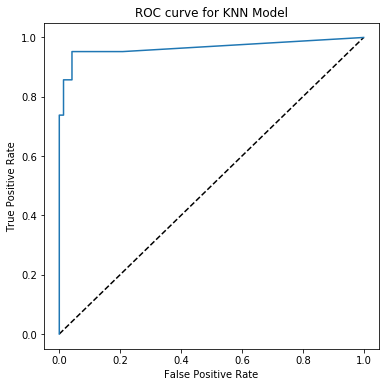

In [43]:
probs = model_knn.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for KNN Model')
plt.show()

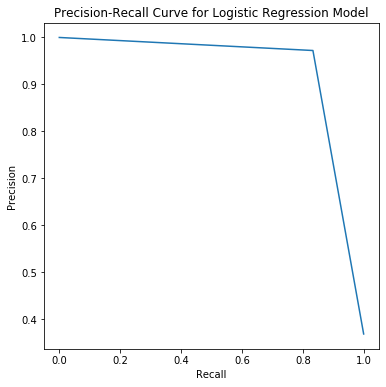

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_knn)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

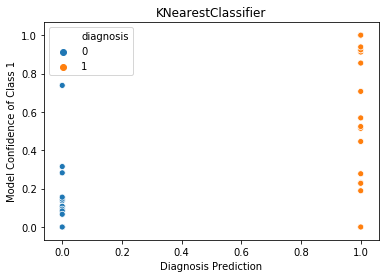

In [18]:
confidence = model_knn.predict_proba(X_test)[:, 1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('KNearestClassifier')
plt.show()

# ROC curve scaled

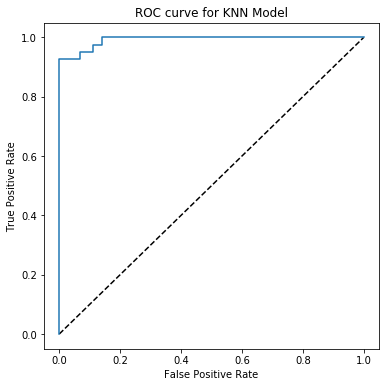

In [27]:
probs = model_knn_scale.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for KNN Model')
plt.show()

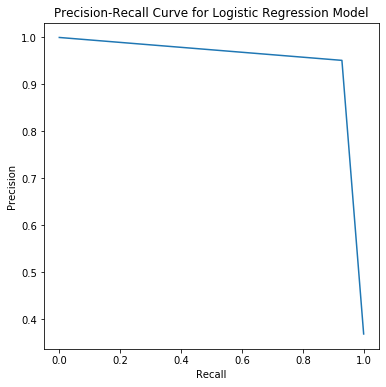

In [46]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_knn_s)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

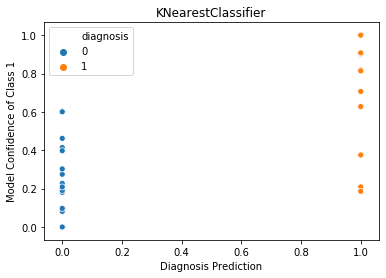

In [19]:
confidence = model_knn_scale.predict_proba(X_test_scaled)[:, 1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('KNearestClassifier')
plt.show()

The scaled model is better because it has better accuracy, recall, and better confidence.